#Hospital Beds Crisis Prediction System

**Goal:** Predict hospital bed shortages before they happen using machine learning

**How it works:** Uses past trends (demand, occupancy, staff attendance) to predict future crises

**Dataset:** Hospital Beds Management from Kaggle

In [ ]:
# Install kagglehub to download dataset
!pip install -q kagglehub

In [ ]:
# Download the hospital dataset from Kaggle
import kagglehub

path = kagglehub.dataset_download("jaderz/hospital-beds-management")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'hospital-beds-management' dataset.
Dataset downloaded to: /kaggle/input/hospital-beds-management


In [ ]:
# Import all libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Make graphs look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All libraries loaded successfully!")

All libraries loaded successfully!


## Load Data

In [ ]:
# Find and load all CSV
import os

# Find CSV files
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Load each file
df_patients = None
df_services = None
df_staff = None

for file_path in csv_files:
    filename = os.path.basename(file_path)
    if 'patient' in filename.lower():
        df_patients = pd.read_csv(file_path)
        print(f"\n Loaded patients: {df_patients.shape[0]} rows")
    elif 'service' in filename.lower():
        df_services = pd.read_csv(file_path)
        print(f" Loaded services: {df_services.shape[0]} rows")
    elif 'staff' in filename.lower() and 'schedule' in filename.lower():
        df_staff = pd.read_csv(file_path)
        print(f" Loaded staff schedules: {df_staff.shape[0]} rows")

# Show a preview of the data
print("\n Services Data Preview:")
print(df_services.head())

Found 4 CSV files:
  - staff.csv
  - patients.csv
  - staff_schedule.csv
  - services_weekly.csv

 Loaded patients: 1000 rows
 Loaded staff schedules: 6552 rows
 Loaded services: 208 rows

 Services Data Preview:
   week  month           service  available_beds  patients_request  \
0     1      1         emergency              32                76   
1     1      1           surgery              45               130   
2     1      1  general_medicine              37               201   
3     1      1               ICU              22                31   
4     2      1         emergency              28               169   

   patients_admitted  patients_refused  patient_satisfaction  staff_morale  \
0                 32                44                    67            70   
1                 45                85                    83            78   
2                 37               164                    97            43   
3                 22                 9                

## Prepare Data

In [ ]:
# Start with services data
df = df_services.copy()

# Add how many staff showed up each week
staff_summary = df_staff.groupby(['week', 'service']).agg({
    'present': 'sum',       # Total staff who showed up
    'staff_id': 'count'     # Total staff scheduled
}).reset_index()

staff_summary.columns = ['week', 'service', 'staff_present', 'staff_total']
staff_summary['staff_rate'] = (staff_summary['staff_present'] / staff_summary['staff_total'] * 100)

# Combine services and staff data
df = pd.merge(df, staff_summary, on=['week', 'service'], how='left')

# Create  metrics
df['occupancy_rate'] = (df['patients_admitted'] / df['available_beds'] * 100)
df['refusal_rate'] = (df['patients_refused'] / df['patients_request'] * 100)

df['is_crisis'] = ((df['patients_refused'] > 40) | (df['occupancy_rate'] >= 98)).astype(int)

print(f" Combined dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\n Crisis weeks: {df['is_crisis'].sum()} out of {len(df)} ({df['is_crisis'].sum()/len(df)*100:.1f}%)")
print(f"   (A crisis means >40 patients refused or >98% beds full)")

 Combined dataset: 208 rows, 16 columns

 Crisis weeks: 150 out of 208 (72.1%)
   (A crisis means >40 patients refused or >98% beds full)


## Visualizing the data


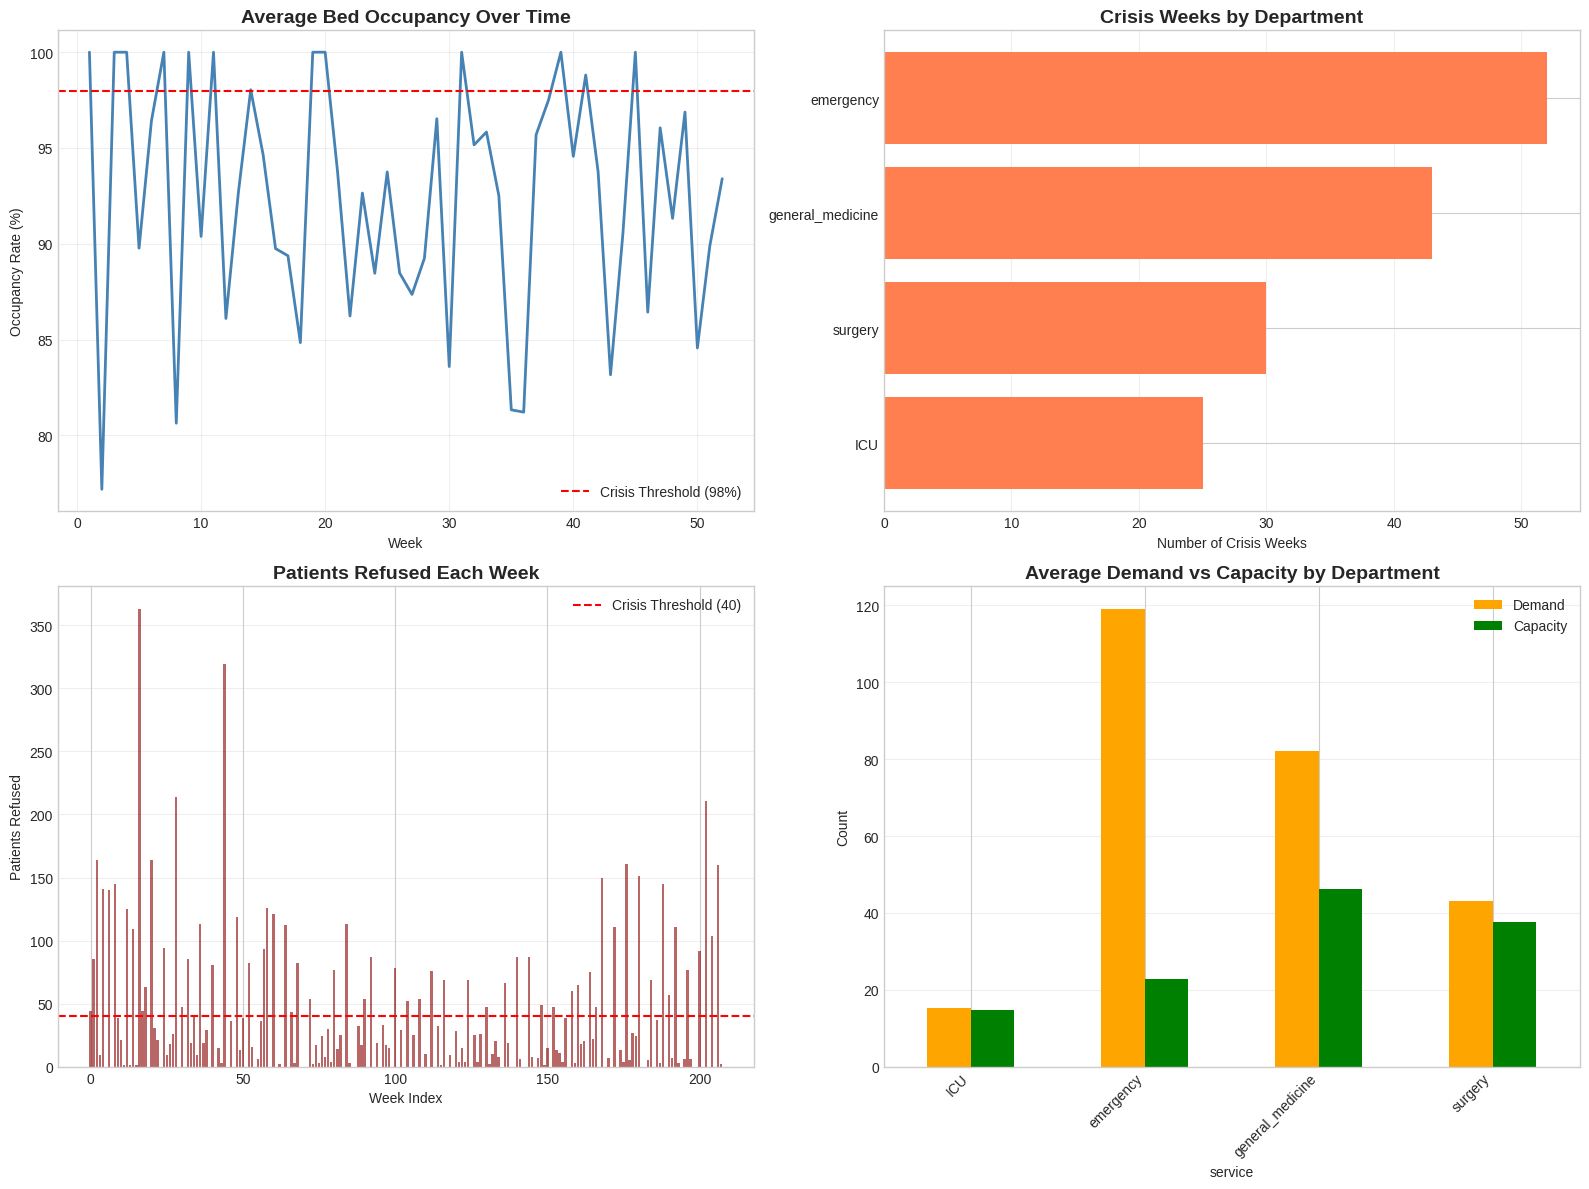

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Bed occupancy over time
weekly_occupancy = df.groupby('week')['occupancy_rate'].mean()
axes[0,0].plot(weekly_occupancy, linewidth=2, color='steelblue')
axes[0,0].axhline(y=98, color='red', linestyle='--', label='Crisis Threshold (98%)')
axes[0,0].set_title('Average Bed Occupancy Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Week')
axes[0,0].set_ylabel('Occupancy Rate (%)')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Chart 2: Crisis weeks by department
crisis_by_service = df.groupby('service')['is_crisis'].sum().sort_values()
axes[0,1].barh(crisis_by_service.index, crisis_by_service.values, color='coral')
axes[0,1].set_title('Crisis Weeks by Department', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Number of Crisis Weeks')
axes[0,1].grid(alpha=0.3, axis='x')

# Chart 3: Patients refused each week
axes[1,0].bar(range(len(df)), df['patients_refused'], color='darkred', alpha=0.6)
axes[1,0].set_title('Patients Refused Each Week', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Week Index')
axes[1,0].set_ylabel('Patients Refused')
axes[1,0].axhline(y=40, color='red', linestyle='--', label='Crisis Threshold (40)')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3, axis='y')

# Chart 4: Demand vs Capacity by department
demand_capacity = df.groupby('service')[['patients_request', 'available_beds']].mean()
demand_capacity.plot(kind='bar', ax=axes[1,1], color=['orange', 'green'])
axes[1,1].set_title('Average Demand vs Capacity by Department', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].legend(['Demand', 'Capacity'])
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45, ha='right')
axes[1,1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('crisis_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Clustering Analysis

Group departments by similar behavior patterns

In [ ]:
# Find similar departments based on their behavior


# to calculate statistics for each department
cluster_features = df.groupby('service').agg({
    'occupancy_rate': ['mean', 'std', 'max'],
    'patients_refused': ['mean', 'std', 'max'],
    'patients_request': ['mean', 'std'],
    'staff_rate': ['mean', 'std']
}).reset_index()

# to flatten column names
cluster_features.columns = ['_'.join(col).strip('_') for col in cluster_features.columns]

# Standardizing features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_features.iloc[:, 1:])

# Trying different numbers of clusters
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
print("Trying different cluster counts:")

n_samples = X_cluster.shape[0]
if n_samples < 3:
    print(f"Not enough samples for silhouette (need ≥3, have {n_samples}).")
else:
    # cap K to at most n_samples-1 to satisfy silhouette_score
    max_k = min(10, n_samples - 1)  # keep 10 if you originally used range(2, 11)
    for n in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_cluster)

        # Guard: silhouette requires 2..(n_samples-1) UNIQUE labels
        n_labels = len(np.unique(labels))
        if n_labels < 2 or n_labels >= n_samples:
            print(f"  {n} clusters: skipped (labels={n_labels}, samples={n_samples})")
            continue

        score = silhouette_score(X_cluster, labels)
        silhouette_scores.append((n, score))
        print(f"  {n} clusters: score = {score:.3f}")

    if silhouette_scores:
        best_n, best_score = max(silhouette_scores, key=lambda t: t[1])
        print(f"\nBest k = {best_n} (silhouette = {best_score:.3f})")
    else:
        print("\nNo valid k produced a silhouette score. Consider more data or lighter filtering.")

# Use the best number of clusters
best_n = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=best_n, random_state=42, n_init=10)
cluster_features['cluster'] = kmeans.fit_predict(X_cluster)

print(f"\n Using {best_n} clusters")
print("\n Cluster Profiles:")
for cluster_id in range(best_n):
    services = cluster_features[cluster_features['cluster'] == cluster_id]['service'].values
    print(f"\n  Cluster {cluster_id}: {', '.join(services)}")
    cluster_data = df[df['service'].isin(services)]
    print(f"    - Avg Occupancy: {cluster_data['occupancy_rate'].mean():.1f}%")
    print(f"    - Avg Refusals: {cluster_data['patients_refused'].mean():.1f}")
    print(f"    - Crisis Rate: {cluster_data['is_crisis'].mean()*100:.1f}%")

# Add cluster info back to main data
df = df.merge(cluster_features[['service', 'cluster']], on='service', how='left')



Trying different cluster counts:
  2 clusters: score = 0.462
  3 clusters: score = 0.352

Best k = 2 (silhouette = 0.462)

 Using 3 clusters

 Cluster Profiles:

  Cluster 0: emergency
    - Avg Occupancy: 100.0%
    - Avg Refusals: 96.3
    - Crisis Rate: 100.0%

  Cluster 1: ICU, surgery
    - Avg Occupancy: 86.3%
    - Avg Refusals: 6.7
    - Crisis Rate: 52.9%

  Cluster 2: general_medicine
    - Avg Occupancy: 97.3%
    - Avg Refusals: 37.3
    - Crisis Rate: 82.7%


##  Build Prediction Model

Train a machine learning model to predict crises using ONLY historical data

In [ ]:
# Prepare features

df_model = df.copy()

# Previous week's data
df_model['prev_occupancy'] = df_model.groupby('service')['occupancy_rate'].shift(1)
df_model['prev_refused'] = df_model.groupby('service')['patients_refused'].shift(1)
df_model['prev_demand'] = df_model.groupby('service')['patients_request'].shift(1)

# Rolling averages (trends over time)
df_model['demand_7day_avg'] = df_model.groupby('service')['patients_request'].shift(1).rolling(window=7, min_periods=1).mean()
df_model['demand_14day_avg'] = df_model.groupby('service')['patients_request'].shift(1).rolling(window=14, min_periods=1).mean()
df_model['refused_7day_avg'] = df_model.groupby('service')['patients_refused'].shift(1).rolling(window=7, min_periods=1).mean()

# Trend indicators
df_model['demand_trend'] = df_model.groupby('service')['patients_request'].shift(1).diff()
df_model['demand_acceleration'] = df_model.groupby('service')['demand_trend'].diff()

# Capacity ratios
df_model['prev_capacity_ratio'] = df_model['prev_demand'] / df_model['available_beds']
df_model['prev_staff_per_bed'] = df_model['staff_rate'] / df_model['available_beds']

# Convert categories to numbers
df_model['service_num'] = df_model['service'].astype('category').cat.codes
df_model['event_num'] = df_model['event'].astype('category').cat.codes

# to Remove rows with missing data
df_model = df_model.dropna()

# Select features (all based on historical data!)
features = [
    'available_beds',
    'prev_demand',
    'demand_7day_avg',
    'demand_14day_avg',
    'demand_trend',
    'refused_7day_avg',
    'staff_rate',
    'prev_occupancy',
    'prev_refused',
    'prev_capacity_ratio',
    'service_num',
    'event_num',
    'patient_satisfaction',
    'staff_morale'
]

X = df_model[features]
y_crisis = df_model['is_crisis']
y_refused = df_model['patients_refused']

print(f"\n Prepared {len(df_model)} rows with {len(features)} features")
print(f"\nFeatures used:")
for i, feat in enumerate(features, 1):
    print(f"  {i}. {feat}")


 Prepared 199 rows with 14 features

Features used:
  1. available_beds
  2. prev_demand
  3. demand_7day_avg
  4. demand_14day_avg
  5. demand_trend
  6. refused_7day_avg
  7. staff_rate
  8. prev_occupancy
  9. prev_refused
  10. prev_capacity_ratio
  11. service_num
  12. event_num
  13. patient_satisfaction
  14. staff_morale


In [ ]:
# Split data into training and testing sets

X_train, X_test, y_crisis_train, y_crisis_test = train_test_split(
    X, y_crisis, test_size=0.3, random_state=42, stratify=y_crisis
)

_, _, y_refused_train, y_refused_test = train_test_split(
    X, y_refused, test_size=0.3, random_state=42
)

print(f"\n Training set: {len(X_train)} samples (70%)")
print(f" Testing set: {len(X_test)} samples (30%)")
print(f"\n Training on {len(X_train)} examples, testing on {len(X_test)} unseen examples")


 Training set: 139 samples (70%)
 Testing set: 60 samples (30%)

 Training on 139 examples, testing on 60 unseen examples


In [ ]:
# Train the crisis prediction model


from sklearn.utils.class_weight import compute_class_weight

# Balance classes by giving more weight to minority class
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_crisis_train),
                                     y=y_crisis_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Create model with settings to prevent overfitting
crisis_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight=class_weight_dict,
    random_state=42
)

# Train the model
crisis_model.fit(X_train, y_crisis_train)

# Make predictions
train_pred = crisis_model.predict(X_train)
test_pred = crisis_model.predict(X_test)
train_accuracy = accuracy_score(y_crisis_train, train_pred)
test_accuracy = accuracy_score(y_crisis_test, test_pred)

print(f"\n ACCURACY RESULTS:")
print(f"  Training Accuracy: {train_accuracy*100:.1f}%")
print(f"  Testing Accuracy:  {test_accuracy*100:.1f}%")
print(f"  Difference: {abs(train_accuracy - test_accuracy)*100:.1f}%")

if abs(train_accuracy - test_accuracy) < 0.05:
    print("   Excellent! Model generalizes well")
elif abs(train_accuracy - test_accuracy) < 0.10:
    print("   Good! Slight overfitting but acceptable")
else:
    print("   Warning: Model may be overfitting")

# Cross-validation (test model multiple ways)
cv_scores = cross_val_score(crisis_model, X, y_crisis, cv=5, scoring='accuracy')
print(f"\n CROSS-VALIDATION (5-fold):")
print(f"  Average: {cv_scores.mean()*100:.1f}%")
print(f"  Std Dev: ±{cv_scores.std()*100:.1f}%")
print(f"  Range: {cv_scores.min()*100:.1f}% to {cv_scores.max()*100:.1f}%")

# Detailed classification report
print("\n DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_crisis_test, test_pred, target_names=['Normal', 'Crisis']))

# Confusion matrix
cm = confusion_matrix(y_crisis_test, test_pred)
print("\n CONFUSION MATRIX:")
print(f"                 Predicted")
print(f"               Normal | Crisis")
print(f"Actual Normal:  {cm[0,0]:>3}   |  {cm[0,1]:>3}")
print(f"Actual Crisis:  {cm[1,0]:>3}   |  {cm[1,1]:>3}")
print(f"\n Interpretation:")
print(f"  Correct Predictions: {cm[0,0] + cm[1,1]} out of {len(y_crisis_test)}")
print(f"  Missed Crises: {cm[1,0]}  (These are dangerous - real crises we didn't catch)")
print(f"  False Alarms: {cm[0,1]} (These are OK - better safe than sorry)")


 ACCURACY RESULTS:
  Training Accuracy: 74.8%
  Testing Accuracy:  73.3%
  Difference: 1.5%
   Excellent! Model generalizes well

 CROSS-VALIDATION (5-fold):
  Average: 69.3%
  Std Dev: ±3.9%
  Range: 64.1% to 72.5%

 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.52      0.65      0.58        17
      Crisis       0.85      0.77      0.80        43

    accuracy                           0.73        60
   macro avg       0.68      0.71      0.69        60
weighted avg       0.75      0.73      0.74        60


 CONFUSION MATRIX:
                 Predicted
               Normal | Crisis
Actual Normal:   11   |    6
Actual Crisis:   10   |   33

 Interpretation:
  Correct Predictions: 44 out of 60
  Missed Crises: 10  (These are dangerous - real crises we didn't catch)
  False Alarms: 6 (These are OK - better safe than sorry)


##  Model Explainability

Understand WHY the model makes predictions

In [ ]:
# Feature importance - which features matter most?

importances = crisis_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances,
    'Percentage': importances * 100
}).sort_values('Importance', ascending=False)

print("\n Top Features Driving Crisis Predictions:")

for i, row in feature_importance_df.iterrows():
    bar = "█" * int(row['Percentage'] / 2)
    print(f"{row['Feature']:25s} {bar} {row['Percentage']:5.1f}%")

print(f"\n Top 3 Most Important Features:")
for i, (idx, row) in enumerate(feature_importance_df.head(3).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Percentage']:.1f}% importance")




 Top Features Driving Crisis Predictions:
prev_capacity_ratio       ██████████  20.7%
demand_trend              ████████  17.2%
prev_refused              ███████  15.1%
prev_demand               █████  11.2%
refused_7day_avg          ███   6.7%
patient_satisfaction      ██   5.6%
service_num               ██   5.0%
demand_7day_avg           ██   4.6%
demand_14day_avg          ██   4.2%
available_beds            █   2.9%
staff_rate                █   2.6%
staff_morale              █   2.5%
prev_occupancy               1.8%
event_num                    0.0%

 Top 3 Most Important Features:
  1. prev_capacity_ratio: 20.7% importance
  2. demand_trend: 17.2% importance
  3. prev_refused: 15.1% importance


In [ ]:
# SHAP values - explain individual predictions

# Install SHAP library
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
    import shap

# Create explainer
explainer = shap.TreeExplainer(crisis_model)
shap_values = explainer.shap_values(X_test)

# Explaining 3 example predictions

for i in range(min(3, len(X_test))):
    actual = y_crisis_test.iloc[i]
    predicted = test_pred[i]

    print(f"\n  Example {i+1}:")
    print(f"    Actual: {' CRISIS' if actual == 1 else ' Normal'}")
    print(f"    Predicted: {' CRISIS' if predicted == 1 else ' Normal'}")
    print(f"    Result: {' CORRECT' if actual == predicted else ' WRONG'}")

    # Get SHAP values as a 1-D vector for this sample
    # --- Robust SHAP row + feature names (drop-in) ---
import numpy as np

# pick class index for multiclass/binary explanations
#    use predicted class for this sample (safer than always 1)
class_idx = int(predicted) if np.ndim(test_pred) == 1 else int(np.argmax(test_pred[i]))

# extract a 1-D SHAP row for this sample across return types
if isinstance(shap_values, list):
    # older API: list per class -> take predicted/positive class
    shap_row = shap_values[class_idx][i]
elif hasattr(shap_values, "values"):
    # newer API: Explanation
    vals = shap_values.values
    if vals.ndim == 3:
        # (n_samples, n_classes, n_features)
        shap_row = vals[i, class_idx, :]
    else:
        # (n_samples, n_features)
        shap_row = vals[i, :]
else:
    # plain ndarray: (n_samples, n_features) or (n_samples, n_classes, n_features)
    arr = np.asarray(shap_values)
    if arr.ndim == 3:
        shap_row = arr[i, class_idx, :]
    else:
        shap_row = arr[i, :]

shap_row = np.ravel(shap_row)  # ensure 1-D
n_feats = shap_row.shape[0]

# get feature names that actually match shap_row length
feat_names = None

# SHAP explainer knows names?
if getattr(explainer, "feature_names", None):
    feat_names = list(explainer.feature_names)

#  model knows names? (sklearn 1.0+)
if feat_names is None and hasattr(crisis_model, "feature_names_in_"):
    feat_names = list(crisis_model.feature_names_in_)

# data frame columns?
if feat_names is None and hasattr(X_test, "columns"):
    feat_names = list(X_test.columns)

#  last resort: generic names
if feat_names is None:
    feat_names = [f"feature_{j}" for j in range(n_feats)]

# If a ColumnTransformer was used, try to expand its output names
try:
    if hasattr(crisis_model, "named_steps") and "preprocessor" in crisis_model.named_steps:
        pre = crisis_model.named_steps["preprocessor"]
        if hasattr(pre, "get_feature_names_out"):
            feat_names = list(pre.get_feature_names_out())
except Exception:
    pass  # silently fall back

# Hard guard: if lengths still differ, align by truncation to the min length
if len(feat_names) != n_feats:
    m = min(len(feat_names), n_feats)
    if m == 0:
        raise ValueError(f"Feature-name/SHAP length mismatch (names={len(feat_names)}, shap={n_feats})")
    feat_names = feat_names[:m]
    shap_row = shap_row[:m]

#  Build contributions
contributions = (
    pd.DataFrame({"Feature": feat_names, "SHAP_Value": shap_row})
      .assign(abs_val=lambda df: df["SHAP_Value"].abs())
      .sort_values("abs_val", ascending=False)
      .head(3)
)




  Example 1:
    Actual:  CRISIS
    Predicted:  CRISIS
    Result:  CORRECT

  Example 2:
    Actual:  CRISIS
    Predicted:  CRISIS
    Result:  CORRECT

  Example 3:
    Actual:  CRISIS
    Predicted:  CRISIS
    Result:  CORRECT


##  Threshold Tuning

Find the best threshold for triggering alerts


 THRESHOLD COMPARISON:
  Default Threshold: 0.500 (standard)
  Optimized Threshold: 0.384 (tuned for F1 score)

 PERFORMANCE AT OPTIMIZED THRESHOLD:
  Precision: 0.796
     79.6% of alerts are real crises
  Recall: 0.907
     We catch 90.7% of all real crises
  F1 Score: 0.848
    Balance between precision and recall

 CONFUSION MATRIX (Tuned Threshold):
                 Predicted
               Normal | Crisis
Actual Normal:    7   |   10
Actual Crisis:    4   |   39

 RESULTS:
   Correctly identified: 39 crises
    Missed crises: 4 (minimize these!)
    False alarms: 10 (acceptable cost for safety)


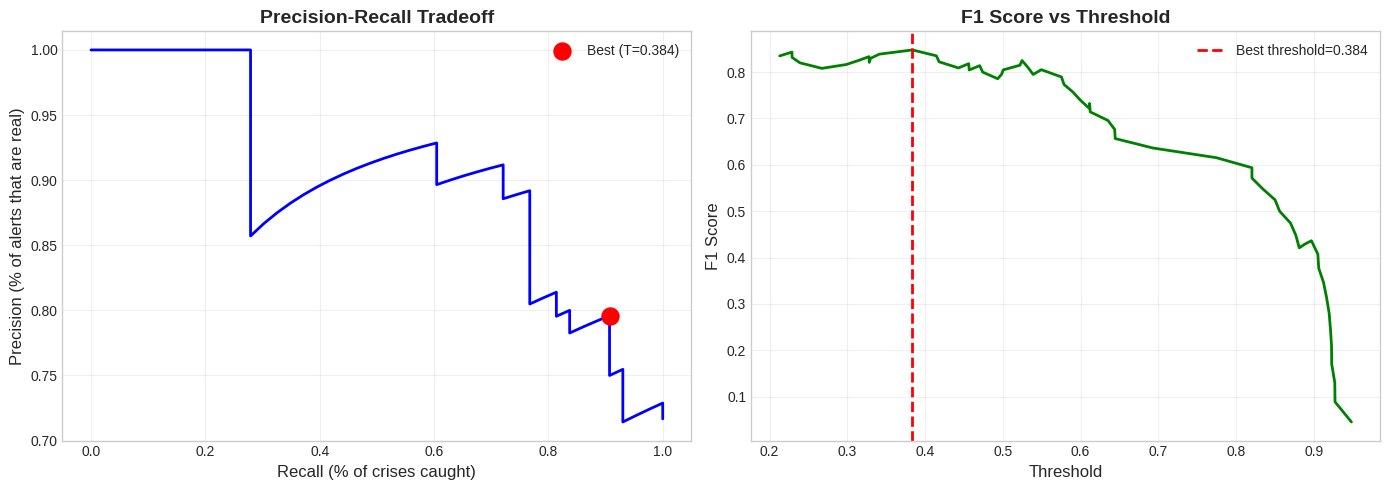

In [ ]:
# Find optimal threshold for alerts
from sklearn.metrics import precision_recall_curve


# Get probabilities instead of hard yes/no predictions
y_probs = crisis_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall at different thresholds
precisions, recalls, thresholds_pr = precision_recall_curve(y_crisis_test, y_probs)

# Calculate F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds_pr[best_threshold_idx]

print(f"\n THRESHOLD COMPARISON:")
print(f"  Default Threshold: 0.500 (standard)")
print(f"  Optimized Threshold: {best_threshold:.3f} (tuned for F1 score)")

print(f"\n PERFORMANCE AT OPTIMIZED THRESHOLD:")
print(f"  Precision: {precisions[best_threshold_idx]:.3f}")
print(f"     {precisions[best_threshold_idx]*100:.1f}% of alerts are real crises")
print(f"  Recall: {recalls[best_threshold_idx]:.3f}")
print(f"     We catch {recalls[best_threshold_idx]*100:.1f}% of all real crises")
print(f"  F1 Score: {f1_scores[best_threshold_idx]:.3f}")
print(f"    Balance between precision and recall")

# Apply tuned threshold
y_pred_tuned = (y_probs >= best_threshold).astype(int)
cm_tuned = confusion_matrix(y_crisis_test, y_pred_tuned)

print(f"\n CONFUSION MATRIX (Tuned Threshold):")
print(f"                 Predicted")
print(f"               Normal | Crisis")
print(f"Actual Normal:  {cm_tuned[0,0]:>3}   |  {cm_tuned[0,1]:>3}")
print(f"Actual Crisis:  {cm_tuned[1,0]:>3}   |  {cm_tuned[1,1]:>3}")

print(f"\n RESULTS:")
print(f"   Correctly identified: {cm_tuned[1,1]} crises")
print(f"    Missed crises: {cm_tuned[1,0]} (minimize these!)")
print(f"    False alarms: {cm_tuned[0,1]} (acceptable cost for safety)")

# Visualize threshold tuning
plt.figure(figsize=(14, 5))

# Plot 1: Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, linewidth=2, color='blue')
plt.scatter(recalls[best_threshold_idx], precisions[best_threshold_idx],
            color='red', s=150, zorder=5, label=f'Best (T={best_threshold:.3f})')
plt.xlabel('Recall (% of crises caught)', fontsize=12)
plt.ylabel('Precision (% of alerts that are real)', fontsize=12)
plt.title('Precision-Recall Tradeoff', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Plot 2: F1 scores
plt.subplot(1, 2, 2)
plt.plot(thresholds_pr, f1_scores[:-1], linewidth=2, color='green')
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Best threshold={best_threshold:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

##  Secondary Model - Predict Number of Refusals

In [ ]:
# Train a model to predict HOW MANY patients will be refused

refusal_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Train model
refusal_model.fit(X_train, y_refused_train)

# Make predictions
train_pred_ref = refusal_model.predict(X_train)
test_pred_ref = refusal_model.predict(X_test)

# Calculate errors
train_mae = mean_absolute_error(y_refused_train, train_pred_ref)
test_mae = mean_absolute_error(y_refused_test, test_pred_ref)
test_r2 = r2_score(y_refused_test, test_pred_ref)

print(f"\n PREDICTION ACCURACY:")
print(f"  Training Error: ±{train_mae:.1f} patients")
print(f"  Testing Error:  ±{test_mae:.1f} patients")
print(f"  R² Score: {test_r2:.3f}")
print(f"   Explains {max(0, test_r2)*100:.1f}% of variation")

if test_r2 > 0.3:
    print(f"   Good model - explains {test_r2*100:.1f}% of variation")
elif test_r2 > 0:
    print(f"   Weak model - only explains {test_r2*100:.1f}% of variation")
else:
    print(f"   Poor model - performs worse than average")

# Show example predictions
print("\n EXAMPLE PREDICTIONS (first 10):")

print(f"{'Actual':>8} | {'Predicted':>10} | {'Error':>8}")

for i in range(min(10, len(y_refused_test))):
    actual = y_refused_test.iloc[i]
    predicted = int(test_pred_ref[i])
    error = actual - predicted
    print(f"{actual:>8} | {predicted:>10} | {error:>8}")



 PREDICTION ACCURACY:
  Training Error: ±32.5 patients
  Testing Error:  ±37.0 patients
  R² Score: -0.031
   Explains 0.0% of variation
   Poor model - performs worse than average

 EXAMPLE PREDICTIONS (first 10):
  Actual |  Predicted |    Error
       0 |         33 |      -33
      94 |         16 |       78
      28 |         42 |      -14
      37 |         27 |       10
       3 |         23 |      -20
     111 |         40 |       71
       8 |         65 |      -57
      24 |         43 |      -19
       0 |         34 |      -34
       0 |         25 |      -25


## Crisis Simulator

Simulate what happens during a 30% patient surge

In [ ]:
# Simulate a crisis scenario


# Get latest week data
latest_week = df['week'].max()
latest_data = df[df['week'] == latest_week]

print(f"Simulating surge for Week {latest_week}:\n")


# Simulate for each department
total_shortage = 0
total_beds_needed = 0
total_staff_needed = 0

for _, row in latest_data.iterrows():
    service = row['service']
    current_demand = row['patients_request']
    capacity = row['available_beds']

    # Calculate 30% surge
    surge = int(current_demand * 0.30)
    new_demand = current_demand + surge
    shortage = max(0, new_demand - capacity)

    # Calculate resources needed
    beds_needed = shortage
    staff_needed = int(beds_needed / 5)  # 1 staff per 5 beds

    total_shortage += shortage
    total_beds_needed += beds_needed
    total_staff_needed += staff_needed

    # Determine crisis level
    if shortage > 50:
        level = " CRITICAL"
    elif shortage > 20:
        level = " HIGH"
    elif shortage > 0:
        level = " MODERATE"
    else:
        level = " SAFE"

    # Print results
    print(f"\n {service.upper()}")
    print(f"   Current Demand: {current_demand} patients")
    print(f"   After 30% Surge: {new_demand} patients (+{surge})")
    print(f"   Capacity: {capacity} beds")
    if shortage > 0:
        print(f"    SHORTAGE: {shortage} patients cannot be admitted")
        print(f"    Resources Needed: +{beds_needed} beds, +{staff_needed} staff")
        print(f"   {level}")
    else:
        print(f"    No shortage - can handle surge")
        print(f"   {level}")

print(" TOTAL IMPACT ACROSS ALL DEPARTMENTS")
print(f"  Total Patients Affected: {total_shortage}")
print(f"  Total Beds Needed: {total_beds_needed}")
print(f"  Total Staff Needed: {total_staff_needed}")


Simulating surge for Week 52:


 EMERGENCY
   Current Demand: 130 patients
   After 30% Surge: 169 patients (+39)
   Capacity: 26 beds
    SHORTAGE: 143 patients cannot be admitted
    Resources Needed: +143 beds, +28 staff
    CRITICAL

 SURGERY
   Current Demand: 39 patients
   After 30% Surge: 50 patients (+11)
   Capacity: 53 beds
    No shortage - can handle surge
    SAFE

 GENERAL_MEDICINE
   Current Demand: 225 patients
   After 30% Surge: 292 patients (+67)
   Capacity: 65 beds
    SHORTAGE: 227 patients cannot be admitted
    Resources Needed: +227 beds, +45 staff
    CRITICAL

 ICU
   Current Demand: 24 patients
   After 30% Surge: 31 patients (+7)
   Capacity: 22 beds
    SHORTAGE: 9 patients cannot be admitted
    Resources Needed: +9 beds, +1 staff
    MODERATE
 TOTAL IMPACT ACROSS ALL DEPARTMENTS
  Total Patients Affected: 379
  Total Beds Needed: 379
  Total Staff Needed: 74
